In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

seed = 42
data = './data/schizotypy/share_430n_interview.csv'

## Import and split dataset

In [7]:
df = pd.read_csv(data)
X_df = df[['PY01', 'PY02', 'PY03', 'PY04', 'PY05', 'PY06', 'PY07', 'PY08', 'PY09', 'PY10', 
        'PY11', 'PY12', 'PY13', 'PY14', 'PY15', 'PB01', 'PB02', 'PB03', 'PB04', 
        'PB05', 'PB06', 'PB07', 'PB08', 'PB09', 'PB10', 'PB11', 'PB12', 'PB13', 
        'PB14', 'PB15', 'MI01', 'MI02', 'MI03', 'MI04', 'MI05', 'MI06', 'MI07', 
        'MI08', 'MI09', 'MI10', 'MI11', 'MI12', 'MI13', 'MI14', 'MI15', 'SA01', 
        'SA02', 'SA03', 'SA04', 'SA05', 'SA06', 'SA07', 'SA08', 'SA09', 'SA10', 
        'SA11', 'SA12', 'SA13', 'SA14', 'SA15', 'gas']]

print('with na:', X_df.shape)

for col in X_df.columns:
    X_df.loc[:,col] = pd.to_numeric(X_df[col], errors='coerce')
X_df = X_df.dropna()
print('drop na:', X_df.shape)

y = X_df['gas'].astype(int)
X = X_df.drop(columns=['gas']).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

with na: (430, 61)
drop na: (402, 61)


## Hyperparameter Gridsearch with Cross-Validation 

In [12]:
param_grid = { 
    'n_estimators': [100, 250, 500, 1000], # this is the number of trees
    'max_features': ['sqrt', 'log2', None], # this is equivalent to mtry in R. I can grid search on integers, but I'll stick with sqrt, log2, and n features 
    'min_samples_leaf': range(1, 11), # this is equivalent to min.node.size
    'criterion' : ['squared_error'], # criterion for splitting
    'random_state': [seed]
} 

grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           verbose=3,)

grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=42;, score=-8.260 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=42;, score=-8.806 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=42;, score=-9.926 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=42;, score=-8.998 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=100, random_state=42;, score=-9.353 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_features=sqrt, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-8.288 total time=   0.3s
[CV 2/5] END criterion=squared_error, max_features=sqrt, min_sample

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error'],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': range(1, 11),
                         'n_estimators': [100, 250, 500, 1000],
                         'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=3)

## Fit Model Using Best Hyperparameters

In [27]:
print('Best Hyperparameters for Random Forest')
print(grid_search.best_params_)

# Fit random forest on data using best parameters
RFregressor = RandomForestRegressor(**grid_search.best_params_, # use the best parameters from the grid search
                                    oob_score=True,)              # allows us to compute out of bag score, R2 by default)
RFregressor.fit(X_train,y_train)

print('Random Forest OOB R2:', round(RFregressor.oob_score_, 3))

RFpreds = RFregressor.predict(X_test)

Best Hyperparameters for Random Forest
{'criterion': 'squared_error', 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 250, 'random_state': 42}
Random Forest OOB R2: 0.157


LinearRegression()

## Compare with Linear Model

Note that the random forest model performs better than the linear regression on the held-out test set. On average, the linear model is 12.22 points removed from the actual score whereas the random forest is only 11.32 points off. Plotting the predicted scores against the actual scores shows a better regression from the random forest. It is also notable that there was one outlier in the test dataset with a very low gas score.

Linear Model RMSE: 12.23
Random Forest RMSE: 11.32


Text(0.5, 1.0, 'Linear Model Prediction vs Actual Labels')

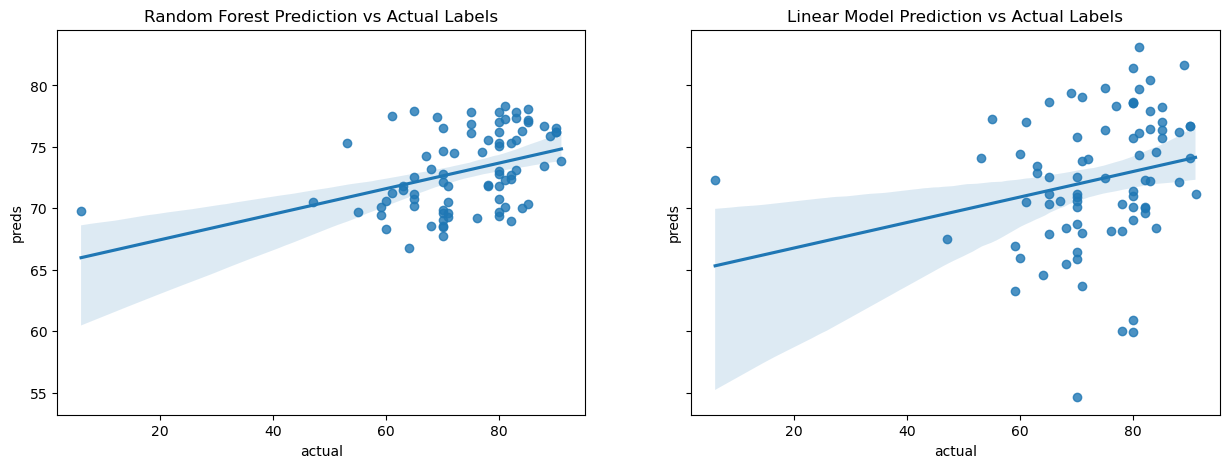

In [38]:
# Fit linear model on data
LMregressor = LinearRegression(fit_intercept=True)
LMregressor.fit(X_train,y_train)
LMpreds = LMregressor.predict(X_test)

print('Linear Model RMSE:', round(mean_squared_error(y_test, LMpreds,  squared=False), 2))
print('Random Forest RMSE:', round(mean_squared_error(y_test, RFpreds, squared=False), 2))

# Plot the error for the two models
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.regplot(pd.DataFrame({'preds':RFpreds, 'actual':y_test}), x='actual', y='preds', ax=ax1)
ax1.set_title('Random Forest Prediction vs Actual Labels')
sns.regplot(pd.DataFrame({'preds':LMpreds, 'actual':y_test}), x='actual', y='preds', ax=ax2)
ax2.set_title('Linear Model Prediction vs Actual Labels')


### Coefficients from the OLS linear model
Here we generate a dataframe the coefficients, p values, and random forest variable importances. We also generate a column to describe the dimension of each indicator

In [120]:
# We have to use OLS from statsmodels because sklearn does not provide p values
mod = OLS(y_train, add_constant(X_train))
res = mod.fit()

df1 = pd.DataFrame({'coefficients':res.params, 'p':res.pvalues}).round(3).reset_index()
df2 = pd.DataFrame({'index':RFregressor.feature_names_in_, 'importance':RFregressor.feature_importances_})

comp_df = pd.merge(df1, df2, on='index', how='outer').sort_values(by='importance')

# Create a dimension column
def assign_category(label):
    if label == 'PY':
        return 'Physical Anhedonia'
    elif label == 'SA':
        return 'Social Anhedonia'
    elif label == 'PB':
        return 'Perceptual Aberration'
    elif label == 'MI':
        return 'Magical Ideation'
    else:
        return None
comp_df['dimension'] = comp_df['index'].apply(lambda x: assign_category(x[0:2]))

### Variable Importances
Here we see all indicators, grouped by dimension and sorted by variable importance. Social anhedonia is the main indicator of Schizotypy, followed by perceptual aberation. 

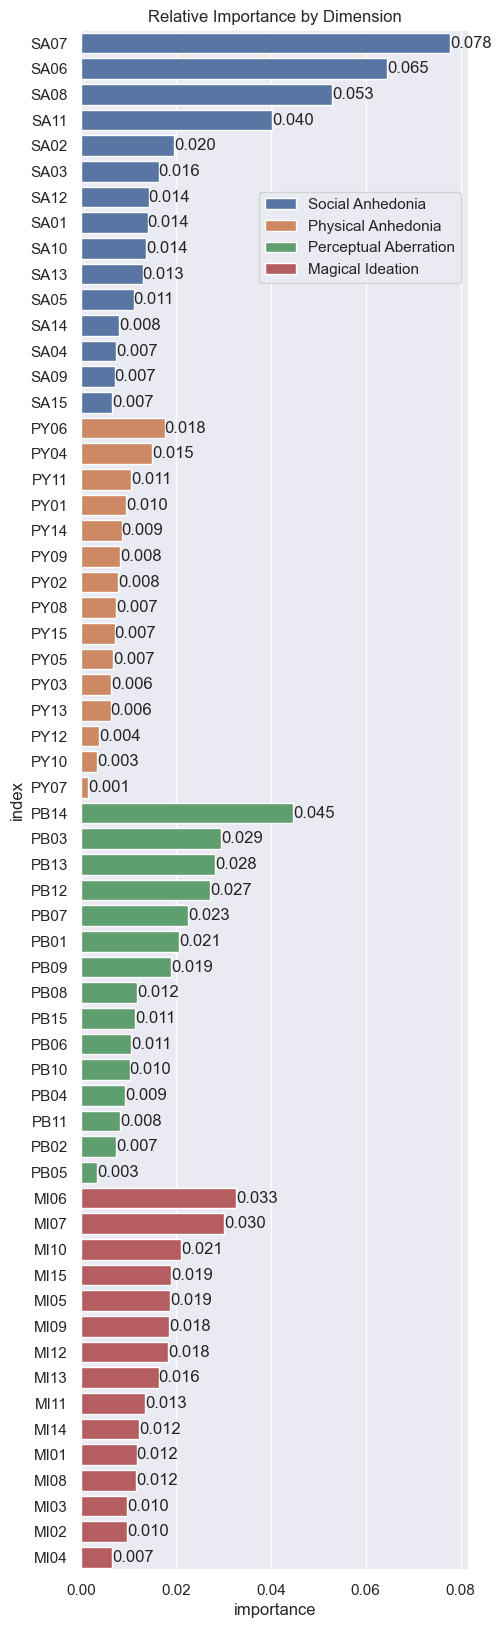

In [121]:
comp_df = comp_df.sort_values(by=['dimension', 'importance'], ascending=False)

plt.figure(figsize=(5,20))
g = sns.barplot(data=comp_df[comp_df['index']!='const'], y='index', x='importance', hue='dimension', legend=True)#, palette=list(comp_df['color']))
for i in g.containers:
    g.bar_label(i,fmt='%.3f')
plt.legend(loc='upper right',
           bbox_to_anchor = [1, 0.9],
           )
plt.title('Relative Importance by Dimension')
plt.show(g)

### Features Used as Roots
The following figure shows how often each of the features are used as the root of a regression tree. We can see that there is a relationship between this statistic and feature importance, although it is not a perfect correlation.

Text(0.5, 0, 'num of trees with feature as root')

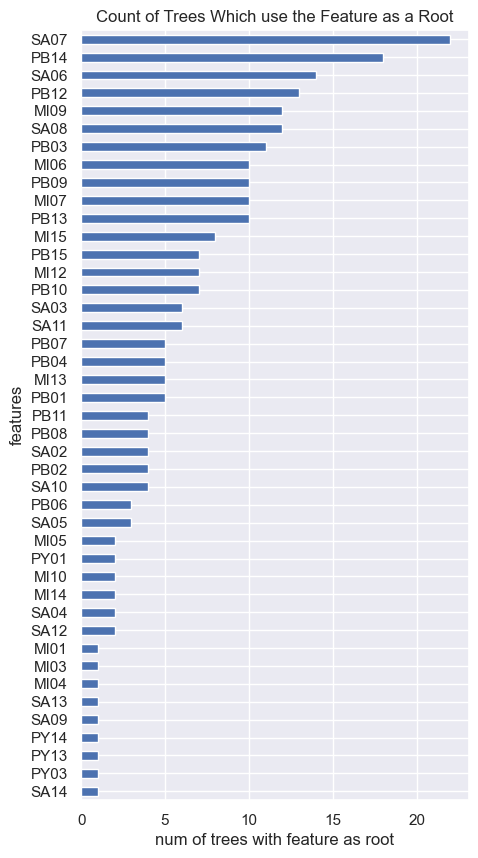

In [162]:
# Get a list of the features used as the root of each tree
roots = []
for estimator in RFregressor.estimators_:
    roots.append(estimator.tree_.feature[0])

# Value count on the features
root_counts_df = pd.DataFrame(roots).value_counts(ascending=True)
roots_counts_index = [x[0] for x in list(root_counts_df.index)]

# Replace the feature numbers with feature names
for (i, feature) in enumerate(RFregressor.feature_names_in_):
    if i in roots_counts_index:
        roots_counts_index[roots_counts_index.index(i)] = feature
root_counts_df.index = roots_counts_index

# Visualize the feature roots
plt.figure(figsize=(5,10))
root_counts_df.plot(kind='barh') 
plt.title('Count of Trees Which use the Feature as a Root')
plt.ylabel('features')
plt.xlabel('num of trees with feature as root')

### Examine differences between p values and variable importances
The figure below shows all variables ranked by relative importance, indicated by the blue bars. The p values are also displayed, indicated by the red bars. The vertical red line indicates the alpha threshold of 0.05. Only four effects were strong enough to be rated as significant by the linear model. Two of them are in the top ten most important variables according to the random forest. Additionally, the more important variables generally had lower p values, as indicated by the pearson's r correlation of -0.3. However, the other two significant variables were not rated highly in importance by the random forest, meaning that they were not often used to split the dataset. Similarly, eight of the top ten most important variables were not statistically significant in the linear model. This indicates that their relationship with the outcome variable may have been non-linear, or may have been mediated by interactions with other variables.

Correlation between importance and p
            importance         p
importance    1.000000 -0.295191
p            -0.295191  1.000000


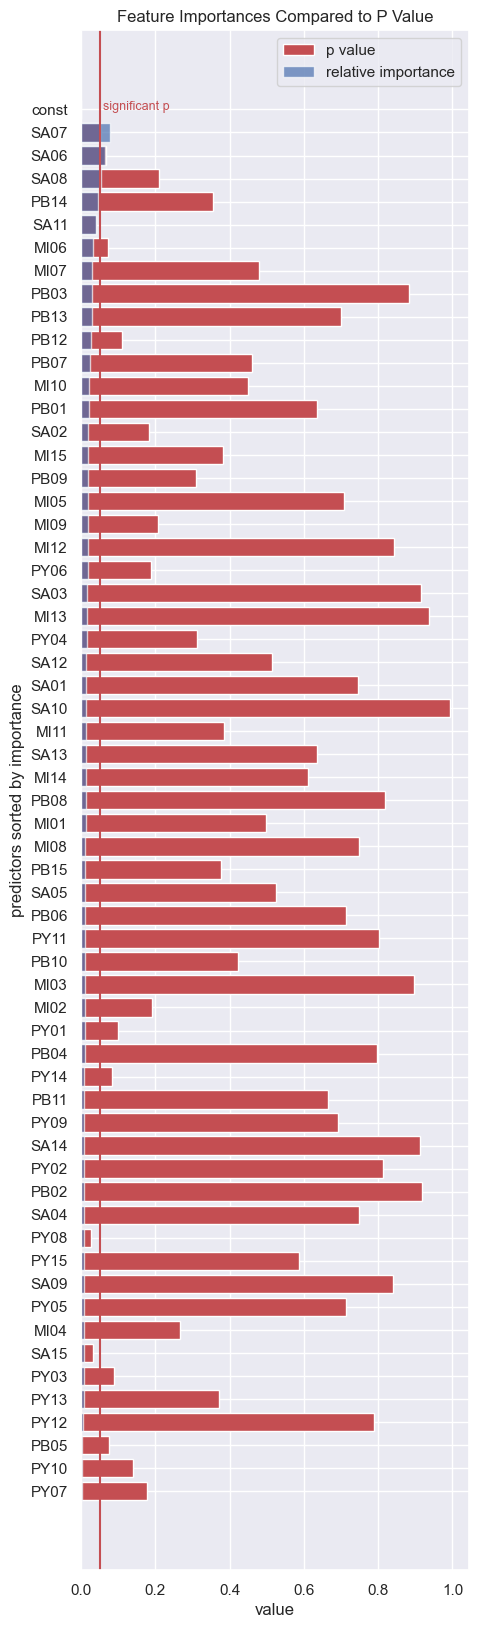

In [119]:
print('Correlation between importance and p')
print(comp_df[['importance', 'p']].corr())

comp_df = comp_df.sort_values(by='importance')
sns.set_theme(style='darkgrid')
plt.figure(figsize=(5,20))

plt.barh(range(len(comp_df)), comp_df['p'], height=0.8, left=None, color='r', align='center', alpha=1, label='p value')
plt.barh(range(len(comp_df)), comp_df['importance'], height=0.8, left=None, color='b', align='center', alpha=0.7, label='relative importance')
plt.yticks(range(len(comp_df)), comp_df['index'])
plt.axvline(x=0.05, color='r')
plt.text(0.06, 60, 'significant p', fontsize = 9, color='r')

plt.title('Feature Importances Compared to P Value')
plt.xlabel('value')
plt.ylabel('predictors sorted by importance')
plt.legend(loc='best')

plt.show()

## Conclusion
Random forest regression is a more powerful tool for prediction than linear regression, as indicated by the lower root mean squared error for random forest (RMSE = 11.32) compared to the linear model (RMSE = 12.23). It is likely that this is because the random forest model is able to account for nonlinear relationships between predictors and outcomes, as well as complex interactions among the predictor variables. As a result, the random forest model was able to use indicators that were non-significant in the linear model. The main drawback of the random forest is that the variable importances are not directional, in the sense that it does not predict whether an increase or decrease in the indicator will lead to better or worse functioning in the outcome. This may unavoidable, however, since we are not making any assumptions about linearity or interactions in our model. It is possible that this problem may be overcome through permutation studies where we synthetically increase or decrease levels of one or more variables while leaving the others static.